In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import os
from tqdm import tqdm  # 进度条
current_path = os.getcwd()

In [44]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
    
    # -- 数据集准备：CIFAR10 (32x32) --
    #    ResNet18预训练模型通常适配224x224，这里简单用Resize到224
transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor()
    ])
    
    # 请确保cifar数据已放在对应目录下(可改成 download=True)
cifar_trainval = datasets.CIFAR10(root=os.path.join(current_path, 'cifar-10-python/'), 
                                      train=True, download=False, transform=transform)
cifar_test = datasets.CIFAR10(root=os.path.join(current_path, 'cifar-10-python/'), 
                                  train=False, download=False, transform=transform)
    
    # 划分训练/验证集
train_size = int(0.8 * len(cifar_trainval))
val_size = len(cifar_trainval) - train_size
cifar_train, cifar_val = random_split(cifar_trainval, [train_size, val_size])
    
train_loader = DataLoader(cifar_train, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(cifar_val,   batch_size=64, shuffle=False, num_workers=2)
test_loader  = DataLoader(cifar_test,  batch_size=32, shuffle=False, num_workers=2)

  0%|          | 0/625 [00:00<?, ?it/s]

tensor(0)


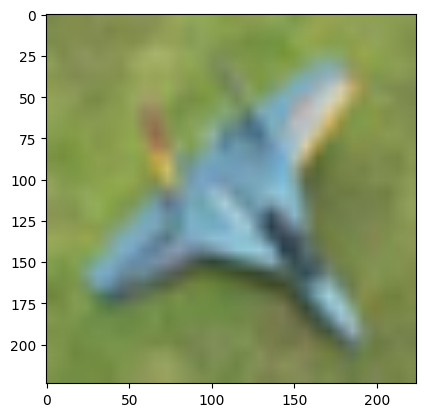

In [45]:
for images, labels in tqdm(train_loader):
    plt.imshow(images[0].permute(1, 2, 0))
    print(labels[0])
    break

In [46]:
from model import ResNetCIFAR10, train_classifier

print("==== 训练分类器(微调ResNet18) ====")
classifier = ResNetCIFAR10(num_classes=10)
    
classifier = train_classifier(classifier, train_loader, val_loader, device, epochs=1, lr=1e-3)

==== 训练分类器(微调ResNet18) ====


Training Epoch 1/1:   0%|          | 0/625 [00:00<?, ?it/s]

Training Epoch 1/1: 100%|██████████| 625/625 [00:42<00:00, 14.56it/s]
                                                                        

[Classifier] Epoch 1/1 | Train Loss: 0.6010 | Val Loss: 0.5118


In [47]:
for images, labels in tqdm(train_loader):
    images = images.to(device)
    y = classifier(images)
    #y = torch.softmax(y, dim=1)
    print(y[0])
    print(labels[0])
    break

  0%|          | 0/625 [00:00<?, ?it/s]

tensor([-7.4515, -5.6023, -3.7151,  5.4448,  0.0172, 11.4946, -2.4415, -1.0942,
        -8.8641, -5.1988], device='cuda:3', grad_fn=<SelectBackward0>)
tensor(5)


In [48]:
from model import generate_decision_labels

combined_dataset = torch.utils.data.ConcatDataset([cifar_train, cifar_val])
combined_loader = DataLoader(combined_dataset, batch_size=64, shuffle=False, num_workers=2)
    
features_tensor, labels_tensor = generate_decision_labels(classifier, combined_loader, device, threshold=0.8)
print(f"特征张量大小: {features_tensor.shape}, 标签张量大小: {labels_tensor.shape}")
positive_ratio = (labels_tensor==1).float().mean().item()


print(f"有 {positive_ratio*100:.2f}% 样本需要原图(置信度低于0.8)")

Generating decision labels: 100%|██████████| 782/782 [00:33<00:00, 23.65it/s]


特征张量大小: torch.Size([50000, 512]), 标签张量大小: torch.Size([50000])
有 31.28% 样本需要原图(置信度低于0.8)


# 下面训练决策网络 

In [49]:
from model import DecisionNet, train_decision_net


decision_net = DecisionNet(input_dim=512, hidden_dim=64)
decision_net = train_decision_net(decision_net, features_tensor, labels_tensor, device, 
                                      epochs=5, lr=1e-3, batch_size=64)

Training DecisionNet Epoch 1/5: 100%|██████████| 782/782 [00:01<00:00, 616.20it/s]


[DecisionNet] Epoch 1/5 | Loss: 0.3227


Training DecisionNet Epoch 2/5: 100%|██████████| 782/782 [00:01<00:00, 593.99it/s]


[DecisionNet] Epoch 2/5 | Loss: 0.2098


Training DecisionNet Epoch 3/5: 100%|██████████| 782/782 [00:01<00:00, 537.73it/s]


[DecisionNet] Epoch 3/5 | Loss: 0.1809


Training DecisionNet Epoch 4/5: 100%|██████████| 782/782 [00:01<00:00, 519.45it/s]


[DecisionNet] Epoch 4/5 | Loss: 0.1684


Training DecisionNet Epoch 5/5: 100%|██████████| 782/782 [00:01<00:00, 522.60it/s]

[DecisionNet] Epoch 5/5 | Loss: 0.1606


==== 评估决策网络 ====

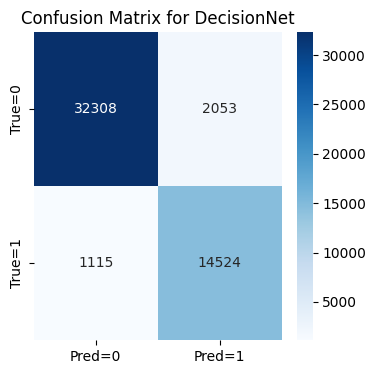

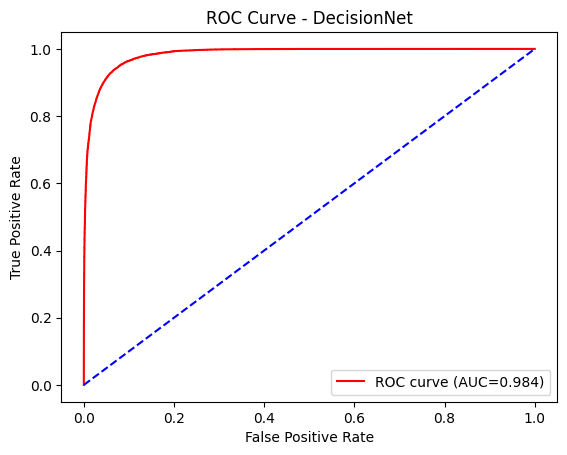

In [50]:
from model import evaluate_decision_net
evaluate_decision_net(decision_net, features_tensor, labels_tensor, device)

In [51]:
class ResNetCIFAR10_serve(nn.Module):
    """
    以预训练的 ResNet18 作为骨干，并修改最后一层输出 10 类 (CIFAR10)。
    """
    def __init__(self, num_classes=10):
        super(ResNetCIFAR10_serve, self).__init__()
        # 加载官方预训练 ResNet18
        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        # 替换最后一层全连接，以适配 CIFAR10 的 10 类
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        # 返回 [B, 10] logits
        return self.model(x)

In [52]:

from model import evaluate_classifier
classifier_serve = ResNetCIFAR10_serve()

def train_classifier(model, train_loader, val_loader, device, epochs=2, lr=1e-3):
    """
    简单示例：微调 ResNet50 用于 CIFAR10 分类，并训练若干 epoch。
    """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        # 训练过程添加进度条
        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        train_loss = running_loss / len(train_loader.dataset)
        val_loss = evaluate_classifier(model, val_loader, device, criterion)
        print(f"[Classifier] Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    return model

classifier_serve = train_classifier(classifier_serve, train_loader, test_loader, device, epochs=5, lr=1e-3)

Training Epoch 1/5: 100%|██████████| 625/625 [01:37<00:00,  6.44it/s]


[Classifier] Epoch 1/5 | Train Loss: 0.5333 | Val Loss: 0.5626


Training Epoch 2/5: 100%|██████████| 625/625 [01:39<00:00,  6.26it/s]


[Classifier] Epoch 2/5 | Train Loss: 0.2924 | Val Loss: 0.3821


Training Epoch 3/5: 100%|██████████| 625/625 [01:37<00:00,  6.38it/s]


[Classifier] Epoch 3/5 | Train Loss: 0.2103 | Val Loss: 0.4259


Training Epoch 4/5: 100%|██████████| 625/625 [01:39<00:00,  6.28it/s]


[Classifier] Epoch 4/5 | Train Loss: 0.1561 | Val Loss: 0.4525


Training Epoch 5/5: 100%|██████████| 625/625 [01:38<00:00,  6.36it/s]
                                                                        

[Classifier] Epoch 5/5 | Train Loss: 0.1249 | Val Loss: 0.3393


In [53]:
class ServeFeaturesClassifier(nn.Module):
    def __init__(self, f_dim=512, num_classes=10):
        super(ServeFeaturesClassifier, self).__init__()  # 使用 super() 来初始化父类
        self.linear = nn.Linear(f_dim, f_dim // 2)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(f_dim // 2, num_classes)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.fc(x)
        return x

In [54]:

from model import evaluate_classifier, FeatureExtractor


backbone = classifier.get_backbone()

def train_feature_classifier(model,backbone, train_loader, val_loader, device, epochs=2, lr=1e-3):
    """
    简单示例：微调 ResNet18 用于 CIFAR10 分类，并训练若干 epoch。
    """
    feature_extractor = FeatureExtractor(backbone).to(device)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        # 训练过程添加进度条
        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            images = images.to(device)
            labels = labels.to(device)

            # 提取特征
            with torch.no_grad():
                features = feature_extractor(images)

            
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        train_loss = running_loss / len(train_loader.dataset)
        #val_loss = evaluate_classifier(model, val_loader, device, criterion)
        print(f"[Classifier] Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} ")
    return model
serve_features_classifer = ServeFeaturesClassifier()
serve_features_classifer = train_feature_classifier(serve_features_classifer,backbone ,train_loader, test_loader, device, epochs=1, lr=1e-3)

Training Epoch 1/1: 100%|██████████| 625/625 [00:23<00:00, 27.17it/s]

[Classifier] Epoch 1/1 | Train Loss: 0.3159 


In [55]:


def test_classifier_accuracy(model, feature_extractor,test_loader, device):
    """
    测试模型在测试集上的准确率
    """
    model.eval()  # 设置模型为评估模式
    correct = 0
    total = 0
    
    with torch.no_grad():  # 不计算梯度，节省内存和计算
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # 提取特征
            features = feature_extractor(images)  # 确保你有 FeatureExtractor 类
            
            outputs = model(features)
            
            # 计算预测准确度
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"[Test] Test Accuracy: {accuracy:.2f}%")
    return accuracy
feature_extractor = FeatureExtractor(backbone).to(device)
test_classifier_accuracy(serve_features_classifer,feature_extractor,test_loader,device)

[Test] Test Accuracy: 87.12%


87.12

In [56]:
import torchvision



def test_classifier_accuracy(model,test_loader, device):
    """
    测试模型在测试集上的准确率
    """
    model.eval()  # 设置模型为评估模式
    correct = 0
    total = 0
    
    with torch.no_grad():  # 不计算梯度，节省内存和计算
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # 提取特征
            # features = feature_extractor(images)  # 确保你有 FeatureExtractor 类
            
            outputs = model(images)
            
            
            # 计算预测准确度
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"[Test] Test Accuracy: {accuracy:.2f}%")
    return accuracy

test_classifier_accuracy(classifier_serve,test_loader,device)

[Test] Test Accuracy: 89.50%


89.5

In [57]:
from model import FeatureExtractor
class Drone:
    """
    无人机：
     - 使用与训练时一致的特征提取方式(固定backbone+fc->128维)，
     - 同时可获取分类置信度(若需要)。这里只演示特征上传给云端。
    """
    def __init__(self, backbone, device):
        self.device = device
        # 用来做128维特征提取
        self.feature_extractor = FeatureExtractor(backbone).to(device)
        self.current_image = None
    
    def capture_image(self, image):
        self.current_image = image  # [3,H,W]
    
    @torch.no_grad()
    def get_feature(self):
        """
        获取当前图像的512维特征
        """
        if self.current_image is None:
            return None
        self.feature_extractor.eval()
        img_batch = self.current_image.unsqueeze(0).to(self.device)  # [1,3,H,W]
        feature = self.feature_extractor(img_batch)  # [1,512]
        return feature.squeeze(0)  # [512]
    
    def send_feature_to_cloud(self, cloud_server):
        feature = self.get_feature()
        if feature is not None:
            return cloud_server.receive_feature(feature, self)
    
    def send_raw_image_to_cloud(self, cloud_server):
        """
        当云端请求原图时，发送
        """
        print("Drone: >>> 上传原图到云端!")
        return cloud_server.receive_raw_image(self.current_image)

In [58]:
class bandwise_limitation:
    def __init__(self,max_frames):
        self.max_frames = max_frames
        self.number = 0
        self.state = False 

    def add(self):
        self.number = self.number+1
    
    def initial(self):
        if not self.state:
            self.number = 0
        self.state = True
    
    def judge(self):
        if self.number <= self.max_frames and self.state:
            return False
        else:
            self.state = False
            return True 
        

abc = bandwise_limitation(5)
print(abc.number,abc.state,abc.judge())
abc.initial()
print(abc.number,abc.state,abc.judge())
abc.add()
print(abc.number,abc.state,abc.judge())
abc.add()
print(abc.number,abc.state,abc.judge())
abc.add()
print(abc.number,abc.state,abc.judge())
abc.add()
print(abc.number,abc.state,abc.judge())
abc.add()
print(abc.number,abc.state,abc.judge())
abc.add()
print(abc.number,abc.state,abc.judge())


0 False True
0 True False
1 True False
2 True False
3 True False
4 True False
5 True False
6 True True


In [59]:
class CloudServer:
    """
    云服务器：接收 512维特征 -> 通过决策网络判断 -> 请求或不请求原图
    """
    def __init__(self, decision_net, device ,features_clf,serve_clf,bandwise_limitation):
        self.decision_net = decision_net.to(device)
        self.device = device
        self.features_clf = features_clf
        self.serve_clf = serve_clf
        self.features_clf.eval()
        self.serve_clf.eval()
        self.features_clf.to(self.device)
        self.serve_clf.to(self.device)
        self.num = 0
        self.abc = bandwise_limitation

    
    def receive_feature(self, feature, drone):
        self.decision_net.eval()
        with torch.no_grad():
            feature = feature.unsqueeze(0).to(self.device)  # [1,128]
            score = torch.sigmoid(self.decision_net(feature))  # [1,1]
            score_val = score.item()
        
        print(f"Cloud: decision score={score_val:.4f}", end=" | ")
        self.abc.add()
        if score_val > 0.5 and not self.abc.judge():
                print("带宽不足")
        if score_val > 0.5 and self.abc.judge():
            self.abc.initial()
            print("需要原图 -> 向无人机请求")
            self.num += 1
            return drone.send_raw_image_to_cloud(self)
            
        else:
           
            print("不需要原图(置信度足够)")
            return self.features_clf(feature)
    
    def receive_raw_image(self, image):
        print(f"Cloud: 已收到原图, 尺寸={tuple(image.shape)}, 在云端执行高阶任务...\n")
        img_batch = image.unsqueeze(0).to(self.device)
        
        y = self.serve_clf(img_batch) 
        return y
        


In [60]:

# ------------------------------------------------------------------------------------
# 8. 模拟在线推理过程
# ------------------------------------------------------------------------------------


def simulate_edge_cloud_inference(drone, cloud_server, test_loader, device, num_images=5):
    print("\n=== 开始『边云协同』在线仿真 ===")
    count = 0
    # 遍历测试集，并使用进度条
    for images, _ in tqdm(test_loader, desc="Simulating edge-cloud inference"):
        for img in images:
            if count >= num_images:
                return
            # 无人机采集图像
            drone.capture_image(img)
            # 无人机端 -> 提取128维特征 -> 上传云端
            print(f"[Image #{count+1}] 无人机先上传特征 -> 云端决策")
            drone.send_feature_to_cloud(cloud_server)
            count += 1

In [61]:
drone = Drone(backbone,device)
abc = bandwise_limitation(3)
cloud_server = CloudServer(decision_net, device,serve_features_classifer,classifier_serve,abc)


In [62]:
def simulate_edge_cloud_inference(drone, cloud_server, test_loader, device, ):
    print("\n=== 开始『边云协同』在线仿真 ===")
    count = 0
    # 遍历测试集，并使用进度条
    correct = 0
    total = 0
    for images, labels in test_loader:
        for i in range(images.size(0)):
            img = images[i]
            label = labels[i]
            
            # 无人机采集图像
            drone.capture_image(img)
            # 无人机端 -> 提取128维特征 -> 上传云端
            print(f"[Image #{count+1}] 无人机先上传特征 -> 云端决策")
            outputs = drone.send_feature_to_cloud(cloud_server)
            
            _, predicted = torch.max(outputs, 1)
            total += 1
            correct += (predicted == label).sum().item()
            count += 1

    accuracy = 100 * correct / total
    print(f"[Test] Test Accuracy: {accuracy:.2f}%")

    print(f"请求原图比例: {cloud_server.num/count:.2f}")
    
    return accuracy
            

simulate_edge_cloud_inference(drone, cloud_server, test_loader, device)         


=== 开始『边云协同』在线仿真 ===
[Image #1] 无人机先上传特征 -> 云端决策
Cloud: decision score=0.0552 | 不需要原图(置信度足够)
[Image #2] 无人机先上传特征 -> 云端决策
Cloud: decision score=0.0678 | 不需要原图(置信度足够)
[Image #3] 无人机先上传特征 -> 云端决策
Cloud: decision score=0.8429 | 需要原图 -> 向无人机请求
Drone: >>> 上传原图到云端!
Cloud: 已收到原图, 尺寸=(3, 224, 224), 在云端执行高阶任务...

[Image #4] 无人机先上传特征 -> 云端决策
Cloud: decision score=0.2565 | 不需要原图(置信度足够)
[Image #5] 无人机先上传特征 -> 云端决策
Cloud: decision score=0.0018 | 不需要原图(置信度足够)
[Image #6] 无人机先上传特征 -> 云端决策
Cloud: decision score=0.9289 | 带宽不足
不需要原图(置信度足够)
[Image #7] 无人机先上传特征 -> 云端决策
Cloud: decision score=0.0085 | 不需要原图(置信度足够)
[Image #8] 无人机先上传特征 -> 云端决策
Cloud: decision score=0.6201 | 需要原图 -> 向无人机请求
Drone: >>> 上传原图到云端!
Cloud: 已收到原图, 尺寸=(3, 224, 224), 在云端执行高阶任务...

[Image #9] 无人机先上传特征 -> 云端决策
Cloud: decision score=0.6233 | 带宽不足
不需要原图(置信度足够)
[Image #10] 无人机先上传特征 -> 云端决策
Cloud: decision score=0.0005 | 不需要原图(置信度足够)
[Image #11] 无人机先上传特征 -> 云端决策
Cloud: decision score=0.9208 | 带宽不足
不需要原图(置信度足够)
[Image #12] 无人机先上传特征 -> 云端决策
Clou

88.31